In [1]:
import numpy as np

import matplotlib.pyplot as plt

microm2m = 1.0E-6
m2microm = 1.0E6

In [2]:

from numpy import linspace, zeros, array, pi, sin, cos, exp, arange
from scipy.fftpack import fft, ifft, dct, idct, dst, idst, fftshift, fftfreq

from math import sqrt
from skimage import data
from skimage.feature import blob_log


import matplotlib.pyplot as plt

from apsg import *



def cartesian_components(D, I, Q, R):
    
    """
    Calculates the cartesian components of  natural remanent magnetization (NRM)
    for uniformily magnetized spheres (mx, my, mz) required in the forward model.

    Parameters:
        * D: 1D-array containing magnetization declination (0 to 360 degrees)
        * I: 1D-array containing magnetization inclination (-90 to 90  degress)
        * Q: 1D-array containing magnetization intensity (A/m)
        * R: 1D-array containing sphere's radius (m)

    Constant:
        * cm: is a constant given by 4*np.pi/µo = 10**(-7) 
            where µo is the vaccum magnetic permeability
    """
    
    
    cm = 10**(-7) # H/m  == T·m/A
    m = []

    for i in range(np.size(D)):
        m_sphere =  np.matrix([[(Q[i]*np.cos(I[i]*(np.pi/180))*np.cos(D[i]*(np.pi/180))) * ((cm*4.0*np.pi*R[i]**3)/3.0) ],
                          [(Q[i]*np.cos(I[i]*(np.pi/180))*np.sin(D[i]*(np.pi/180))) * ((cm*4.0*np.pi*R[i]**3)/3.0) ],
                           [(Q[i]*np.sin(I[i]*(np.pi/180)))*((cm*4.0*np.pi*R[i]**3)/3.0)                            ]])

        m = np.append(m,m_sphere)
        
    return(np.array(m))



def sensibility_matrix(X, Y, Z, Xc, Yc, Zc): 
    
    """
    Generates the sensibility matrix for vertical component of magnetization

    Parameters:
        *  X,  Y,  Z: 1D-arrays with x, y and z data positions
        * Xc, Yc, Zc: 1D-arrays with x, y and z data  of the sphere's center positions
    """

    dzz = np.zeros(np.shape(Z))
    dxz = np.zeros(np.shape(Z))
    dzy = np.zeros(np.shape(Z))


    for j in range(len(Xc)):
        for i in range(len(X)):
            dzz[i] =  -1.0*( (X[i]-Xc[j])**2+(Y[i]-Yc[j])**2-2*(Z[i]-Zc[j])**2) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            dxz[i] = ( 3.0*(X[i]-Xc[j])*(Z[i]-Zc[j]) ) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            dzy[i] = ( 3.0*(Z[i]-Zc[j])*(Y[i]-Yc[j]) ) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            
        M = ([[dxz],[dzy],[dzz]])
        
        M = np.reshape(M, (3, np.size(dzz)))
        M.T
        
        if j==0:
            Mz = np.copy(M)
        else:
            Mz = np.concatenate((Mz,M), axis=0)


    return(Mz.T) # sensibility matrix                    
    


def regular(area, shape, z=None):
    
    """
    Generates the regular grid --> source https://legacy.fatiando.org/cookbook.html

    Parameters:
        * area: array with x axis size (nx) and y axis size (ny)
        * shape: array with min(x), max(x), min(y) and max(y)
        * z: float with the distance between the sample surface and the sensor
    """
    
    nx, ny = shape
    x1, x2, y1, y2 = area
    xs = np.linspace(x1, x2, nx)
    ys = np.linspace(y1, y2, ny)
    
    arrays = np.meshgrid(ys, xs)[::-1]
    
    if z is not None:
        arrays.append(z*np.ones(nx*ny, dtype=np.float64))
    return [i.ravel() for i in arrays]



def noise(data, error=0.05):
    
    """
    Generates a Gaussian noise (normal distribution, mean equals zero, and desv. pad. equals the error percent input)

    Parameters:
        * data: simulated data vector
        * percent_erro: error percentage (default = 5%) based on the maximum amplitude of the anomaly 

    """
    
    sigma_noise = (np.absolute(np.max(data))+np.absolute(np.min(data))) * error
    noise_vector = np.array(np.random.normal(0,sigma_noise,len(data)))
    noise_vector = np.transpose(noise_vector)

    data_noise = data+noise_vector
 
    return (data_noise)


def derivative_fd(data_2D, X, Y, order=1):
    x_derivative=np.zeros(np.shape(data_2D))
    y_derivative=np.zeros(np.shape(data_2D))
    
    
    for i in range(np.shape(X)[0]-1):
        for j in range(np.shape(Y)[1]-1):
            x_derivative[i,j]=np.array((data_2D[i+1,j]-data_2D[i-1,j])/(X[i+1,j]-X[i-1,j]))
            y_derivative[i,j]=np.array((data_2D[i, j+1]-data_2D[i,j-1])/(Y[i,j+1]-Y[i,j-1]))
            
    if order>1:
        x_derivative, _  = derivative_fd(x_derivative, X, Y, order=order-1)
        _,  y_derivative = derivative_fd(y_derivative, X, Y, order=order-1)
            
    
    
    # boundary conditions
    x_derivative[ 0, :] = x_derivative[1 , :]
    x_derivative[-1, :] = x_derivative[-2, :]
    y_derivative[: , 0] = y_derivative[: , 1]
    y_derivative[: ,-1] = y_derivative[: ,-2]
    
    
    return(x_derivative, y_derivative)



def wave_numbers(data_2D, X, Y): 
    
    wx = np.zeros(np.shape(data_2D))
    wy = np.zeros(np.shape(data_2D))
    
    nx, ny = np.shape(data_2D)
    y_step = (np.max(Y) - np.min(Y)) / (ny-1)
    x_step = (np.max(X) - np.min(X)) / (nx-1)
    
    # x frequency
    for j in range(np.shape(data_2D)[1]):
        kx = np.fft.fftfreq(nx, x_step)
        wx[:,j] = 2*np.pi*kx  # wave number in x direction

    # y frequency
    for i in range(np.shape(data_2D)[0]):
        ky = np.fft.fftfreq(ny, y_step)
        wy[i,:] = 2*np.pi*ky   # wave number in y direction
    
    # radial wave number
    wz = np.sqrt(wx**2+wy**2) 

    return(wx, wy, wz)



def y_derivative_fft(data_2D, wy, order=1): 
    
    f_hat = np.fft.fft2(data_2D)
    derivative_factor = (1j*wy)**order
    
    y_derivative = np.real(np.fft.ifft2(derivative_factor*f_hat))
    
    # boundary conditions
    y_derivative[0 , :] = y_derivative[1 , :]
    y_derivative[-1, :] = y_derivative[-2, :]
    y_derivative[: , 0] = y_derivative[: , 1]
    y_derivative[: ,-1] = y_derivative[: ,-2]
    
    return(y_derivative)



def x_derivative_fft(data_2D, wx, order=1): 
    
    f_hat = np.fft.fft2(data_2D)
    derivative_factor = (1j*wx)**order
    
    x_derivative = np.real(np.fft.ifft2(derivative_factor*f_hat))
    
    # boundary conditions
    x_derivative[0 , :] = x_derivative[1 , :]
    x_derivative[-1, :] = x_derivative[-2, :]
    x_derivative[: , 0] = x_derivative[: , 1]
    x_derivative[: ,-1] = x_derivative[: ,-2]

    return(x_derivative)



def z_derivative_fft(data_2D, wz, order=1): 
    
    f_hat = np.fft.fft2(data_2D)
    derivative_factor = wz**order
    
    z_derivative = np.real(np.fft.ifft2(derivative_factor*f_hat))
    
    # boundary conditions
    z_derivative[0 , :] = z_derivative[1 , :]
    z_derivative[-1, :] = z_derivative[-2, :]
    z_derivative[: , 0] = z_derivative[: , 1]
    z_derivative[: ,-1] = z_derivative[: ,-2]
    
    return(z_derivative)



def upward_continuation(data_2D, delta_z, wz):
    
    f_hat = np.fft.fft2(data_2D)                 
    up_cont_factor = np.exp((delta_z)*(wz))
    
    up_cont = np.real(np.fft.ifft2(f_hat*up_cont_factor))
    
    # boundary conditions
    up_cont[ 0, :] = up_cont[1 , :]
    up_cont[-1, :] = up_cont[-2, :]
    up_cont[: , 0] = up_cont[: , 1]
    up_cont[: ,-1] = up_cont[: ,-2]
    
    return(up_cont)



def z_derivative_fd(upward_1, upward_2, delta_Z1, delta_Z2):
    z_derivative = np.zeros(np.shape(upward_1))
        
    for i in range(np.shape(upward_1)[0]-1):
        for j in range(np.shape(upward_1)[1]-1):
            z_derivative[i,j]=np.array((upward_1[i,j]-upward_2[i,j])/(np.absolute(delta_Z2 - delta_Z1)))
    
    return(z_derivative)




def Horiz_Grad(x_derivative, y_derivative): 
    
    horizontal_gradient = np.sqrt(np.absolute(y_derivative**2+x_derivative**2))
    
    return(horizontal_gradient)



def sources_finder(Horiz_Grad, threshold=0.05, data = [], overlap=0.5, radius_increment=0.2):
    
    input_data = (Horiz_Grad / Horiz_Grad.max())  # normalized data (0<= data <=1)
    
    blobs_log = blob_log(input_data, min_sigma=2, max_sigma=100, num_sigma=100, threshold = threshold, overlap=overlap)


    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_list = [blobs_log]
    colors = ['yellow']
    titles = ['Localização de Fontes (Laplacian of Gaussian)']
    sequence = zip(blobs_list, colors, titles)

    circles = []

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(1, 1, 1)
    for idx, (blobs, color, title) in enumerate(sequence):
        plt.title(title, fontsize=18)
        
        if np.size(data)==0:
            plt.imshow(input_data)
        else:
            plt.imshow(data)
        plt.gca().invert_yaxis()
        for blob in blobs:
            y, x, r = blob
            if (r>=2) & (r<=50): 
                circles = np.append(circles, [np.round(y),np.round(x),np.round(r + radius_increment*r)])
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax.add_patch(c)

    plt.tight_layout()
    plt.show()
    
    
    circles_T = np.reshape(circles, (int(np.size(circles)/3),3))

    euler_windows = []

    for i in range(np.shape(circles_T)[0]):
            x1 = int(circles_T[i,0]-circles_T[i,2])
            x2 = int(circles_T[i,0]+circles_T[i,2])
            y1 = int(circles_T[i,1]-circles_T[i,2])
            y2 = int(circles_T[i,1]+circles_T[i,2])
            
            if (x1>=0) & (x2<=np.shape(input_data)[0]) & (y1>=0) & (y2<=np.shape(input_data)[1]):         
                euler_windows = np.append(euler_windows, ([x1, x2, y1, y2]) )
                
    euler_windows_T = np.reshape(euler_windows, (int(np.size(euler_windows)/4),4))

    return(circles, euler_windows_T)
    

    
def euler_windows_view(X_, Y_, Z_, d_, ddx, ddy, ddz, euler_windows_T, show_windows=False, color='y'):
    
    nx, ny = np.shape(d_)
    y_step = (np.max(Y_)*m2microm - np.min(Y_)*m2microm) / (ny-1)
    x_step = (np.max(X_)*m2microm - np.min(X_)*m2microm) / (nx-1)
    
    plt.figure()
    plt.contourf(Y_*m2microm, X_*m2microm, d_, cmap='jet')
    
    for i in range(np.shape(euler_windows_T)[0]):
        x1 = int(euler_windows_T[i,0]) * x_step
        x2 = int(euler_windows_T[i,1]) * x_step
        y1 = int(euler_windows_T[i,2]) * y_step
        y2 = int(euler_windows_T[i,3]) * y_step
        
        plt.hlines(x1, y1, y2, color=color)
        plt.hlines(x2, y1, y2, color=color)
        plt.vlines(y1, x1, x2, color=color)
        plt.vlines(y2, x1, x2, color=color)
    
    if show_windows:
    
        for i in range(np.shape(euler_windows_T)[0]):
            x1 = int(euler_windows_T[i,0])
            x2 = int(euler_windows_T[i,1])
            y1 = int(euler_windows_T[i,2])
            y2 = int(euler_windows_T[i,3])

            plt.figure()
            plt.contourf(Y_[x1:x2, y1:y2]*m2microm, X_[x1:x2, y1:y2]*m2microm, d_[x1:x2, y1:y2])
    

    
    return()
   

def solve_euler(X_, Y_, Z_, d_, ddx, ddy, ddz, delta_z, structural_index = 3.0):
    

    # first member --> components of A matrix
    d_X_ = np.array(np.reshape(ddx, (np.size(ddx),1)))
    d_Y_ = np.array(np.reshape(ddy, (np.size(ddy),1)))
    d_Z_ = np.array(np.reshape(ddz, (np.size(ddz),1)))
    ni   = np.array(np.ones(np.shape(d_X_))*structural_index)

    A = np.zeros((np.size(d_X_), 4))
    A[:,0] = d_X_[:,0]
    A[:,1] = d_Y_[:,0]
    A[:,2] = d_Z_[:,0]
    A[:,3] =   ni[:,0]

    # second member --> vector B
    X_1  = np.array(np.reshape(X_, (np.size(X_),1)))
    Y_1  = np.array(np.reshape(Y_, (np.size(Y_),1)))
    Z_1  = np.array(np.reshape(Z_, (np.size(Z_),1))) + delta_z
    ni_d = structural_index*d_
    ni_d_ = np.array(np.reshape(ni_d, (np.size(ni_d),1)))

    B = (X_1[:,:]*d_X_[:,:]) + (Y_1[:,:]*d_Y_[:,:]) + ((Z_1[:,:])*d_Z_[:,:])  + (ni_d_)

    # solving linear system using least square
    A_T = np.transpose(A)
    A_T_A = np.matmul(A_T, A)
    A_T_B = np.matmul(A_T, B)
    C = np.matmul(np.linalg.inv(A_T_A), A_T_B)
    
    return(C[0],C[1],C[2])




def solve_euler_windows(euler_windows, X_, Y_, Z_, d_, ddx, ddy, ddz, delta_z, structural_index = 3.0):
    euler_position = []
    for i in range(np.shape(euler_windows)[0]):
        x1 = int(euler_windows[i, 0])
        x2 = int(euler_windows[i, 1])
        y1 = int(euler_windows[i, 2])
        y2 = int(euler_windows[i, 3])
        source_position = solve_euler( X_[x1:x2, y1:y2], Y_[x1:x2, y1:y2], Z_[x1:x2, y1:y2], d_[x1:x2, y1:y2], 
                                      ddx[x1:x2, y1:y2], ddy[x1:x2, y1:y2], ddz[x1:x2, y1:y2], 
                                      delta_z, structural_index = 3.0)
        euler_position = np.append(euler_position, source_position)

    euler_position = np.reshape(euler_position, (int(np.size(euler_position)/3),3))
    
    Xc = []
    Yc = []
    Zc = []
    
    for row in range (np.shape(euler_position)[0]):
        Xc = np.append(Xc, euler_position[row, 0] )
        Yc = np.append(Yc, euler_position[row, 1] )
        Zc = np.append(Zc, euler_position[row, 2] )
        
    
    return(Xc, Yc, Zc)




















def sources_finder(Horiz_Grad, data = [], threshold=0.05, min_sigma=1, max_sigma=100, num_sigma=50, overlap=0.5, radius_increment=0.2):
    
    input_data = (Horiz_Grad / Horiz_Grad.max())  # normalized data (0<= data <=1)
    
    
    
    #blobs_log = blob_log(input_data, min_sigma=2, max_sigma=100, num_sigma=100, threshold = threshold, overlap=overlap)
    blobs_log = blob_log(input_data,  min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold = threshold, overlap=overlap)

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_list = [blobs_log]
    colors = ['yellow']
    titles = ['Localização de Fontes (Laplacian of Gaussian)']
    sequence = zip(blobs_list, colors, titles)

    circles = []

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(1, 1, 1)
    for idx, (blobs, color, title) in enumerate(sequence):
        plt.title(title, fontsize=18)
        
        if np.size(data)==0:
            plt.imshow(input_data)
        else:
            plt.imshow(data)
        plt.gca().invert_yaxis()
        for blob in blobs:
            y, x, r = blob
            if (r>=2): 
                circles = np.append(circles, [np.round(y),np.round(x),np.round(r + radius_increment*r)])
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax.add_patch(c)

    plt.tight_layout()
    plt.show()
    
    
    circles_T = np.reshape(circles, (int(np.size(circles)/3),3))
    
    for i in range(np.shape(circles_T)[0]):
        for j in range(np.shape(circles_T)[0]):
            if (circles_T[i,2] > circles_T[j,2]):
                bubble1, bubble2, bubble3 = circles_T[i,0], circles_T[i,1], circles_T[i,2]
                circles_T[i,0], circles_T[i,1], circles_T[i,2] = circles_T[j,0], circles_T[j,1], circles_T[j,2]
                circles_T[j,0], circles_T[j,1], circles_T[j,2] = bubble1, bubble2, bubble3

                
    ###################################
    
    # remove larger circles wrappind smaller ones
    circles_teste = []
    for i in range(np.shape(circles_T)[0]):
        for j in range(np.shape(circles_T)[0]):
            center_distance = np.sqrt( (circles_T[i, 0]-circles_T[j, 0])**2 + (circles_T[i, 1]-circles_T[j, 1])**2 )
            radius_sum = np.absolute(circles_T[i, 2] + circles_T[j, 2])
            radius_dif = np.absolute(circles_T[i, 2] - circles_T[j, 2])
             
            if i != j:
                if (center_distance <= radius_dif) or (center_distance <= 0.5*radius_sum) or (int(center_distance)==0):
                #if ((center_distance + circles_T[j, 2]) < circles_T[i, 2]):
                    if circles_T[i, 2] < circles_T[j, 2]:
                        circles_teste.append(circles_T[j, 0])
                        circles_teste.append(circles_T[j, 1])
                        circles_teste.append(circles_T[j, 2])

                    

    circles_teste = np.reshape(circles_teste, (int(np.size(circles_teste)/3),3))

    for i in circles_teste:  
        salva = []
        delete = (circles_T==i)
        for j in range(np.shape(delete)[0]):
            if delete[j, 0]==True & delete[j, 1]==True & delete[j, 2]==True:
                salva.append(True)
            else:
                salva.append(False)
        circles_T = np.delete(circles_T, salva, 0)
    
    #####################################

    
    euler_windows = []

    for i in range(np.shape(circles_T)[0]):
            x1 = int(circles_T[i,0]-circles_T[i,2])
            x2 = int(circles_T[i,0]+circles_T[i,2])
            y1 = int(circles_T[i,1]-circles_T[i,2])
            y2 = int(circles_T[i,1]+circles_T[i,2])
            
            if (x1>=0) & (x2<=np.shape(input_data)[0]) & (y1>=0) & (y2<=np.shape(input_data)[1]):         
                euler_windows = np.append(euler_windows, ([x1, x2, y1, y2]) )
                
    euler_windows_T = np.reshape(euler_windows, (int(np.size(euler_windows)/4),4))

    return(circles, euler_windows_T)

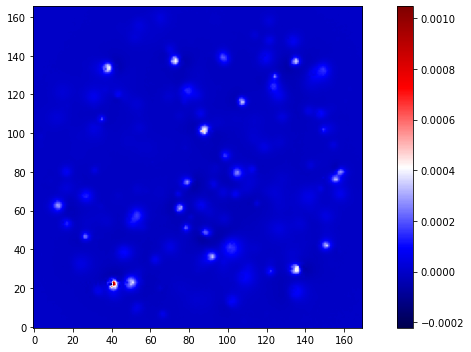

In [3]:
df = np.loadtxt('Bz.csv', delimiter=';', skiprows=0)

# df = df[0:60, 30:80]

plt.figure(figsize=(10,5))
plt.imshow(df, cmap='seismic')
plt.colorbar()
plt.gca().invert_yaxis()

plt.tight_layout()


In [4]:
d = np.reshape(df, (np.size(df),1))
d_ = np.reshape(d, np.shape(df))


voo = 6.0
area = (0, (np.shape(df)[0])*microm2m, 0, (np.shape(df)[1])*microm2m)
shape = np.shape(df)
z = -voo*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A

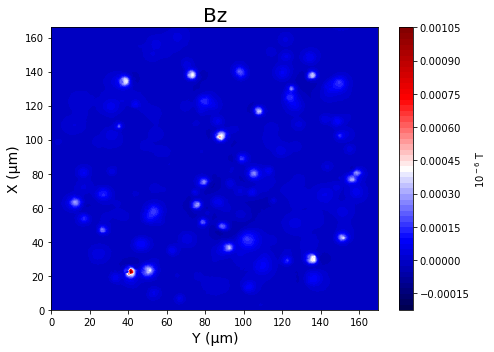

In [5]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(7, 5))
plt.contourf(x_plot, y_plot, d_, levels=50, cmap='seismic')
plt.colorbar(label='10$^-$$^6$ T')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

plt.tight_layout()

plt.show()

In [7]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


Text(0, 0.5, 'X (µm)')

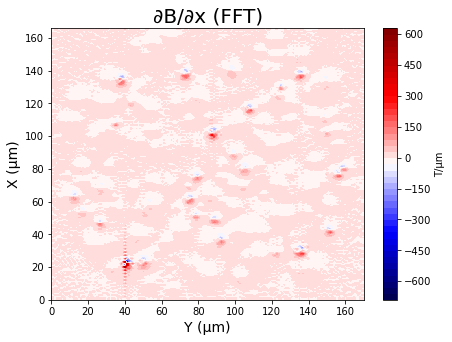

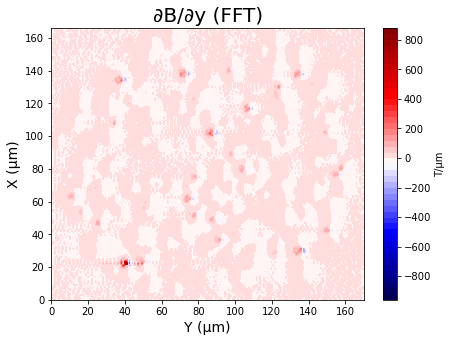

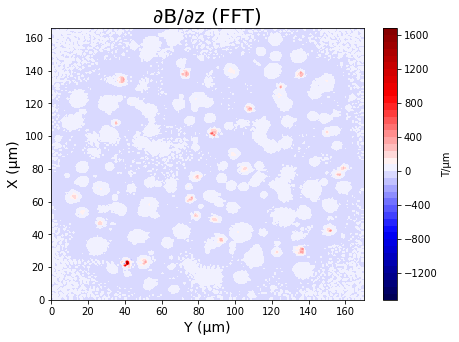

In [8]:
# plot das derivadas por FFT

plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, ddx, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂x (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, ddy, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂y (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, ddz, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂z (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



Text(0, 0.5, 'X (µm)')

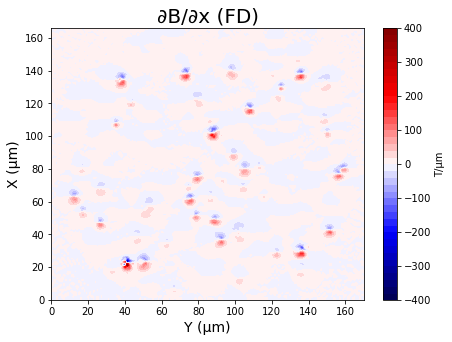

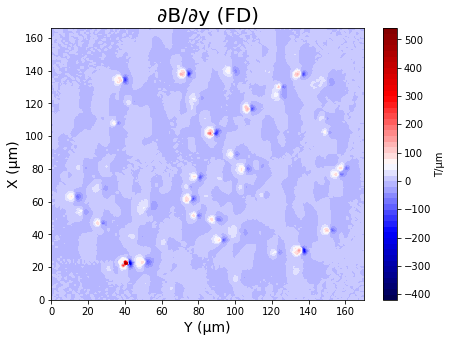

In [9]:
# plot das derivadas por FD

plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, d_X, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂x (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, d_Y, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂y (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

In [10]:
# Calculo dos gradientes horizontais por FFT e FD

Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

Text(0, 0.5, 'X (µm)')

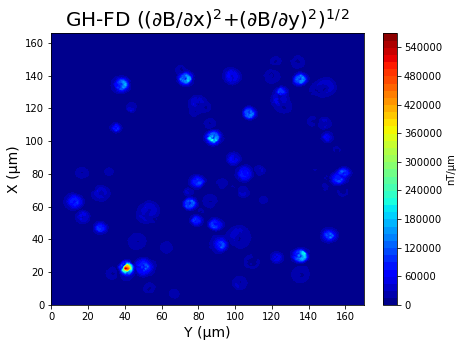

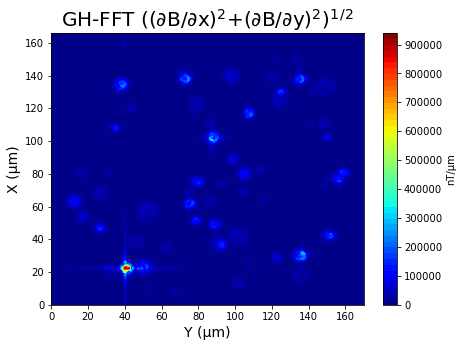

In [11]:
# Plot dos gradientes horizontais por FFT e FD

plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

In [22]:
# upward_continuation filtering --> to remove high frequency noise
height = 0.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

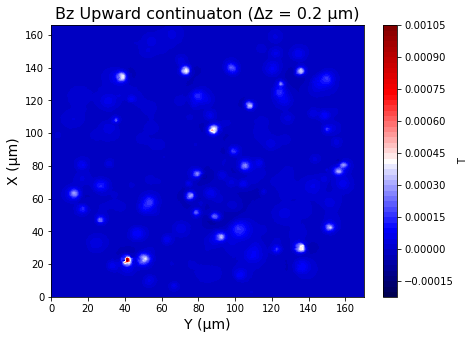

In [23]:
# Plot da Continuação p/ cima

plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, (upward), levels=50, cmap='seismic')
plt.colorbar(label='T')

plt.title('Bz Upward continuaton (Δz = %s µm)'%altura, fontsize=16)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [24]:
# New derivatives by FFT
ddy = y_derivative_fft(upward, wy)
ddx = x_derivative_fft(upward, wx)
ddz = z_derivative_fft(upward, wz)



Text(0, 0.5, 'X (µm)')

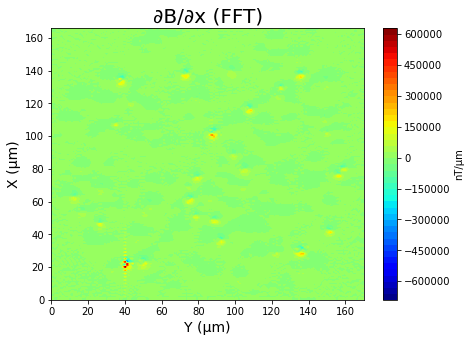

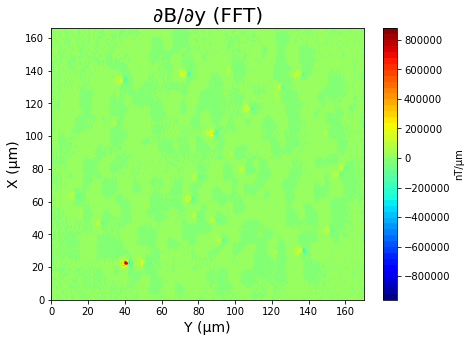

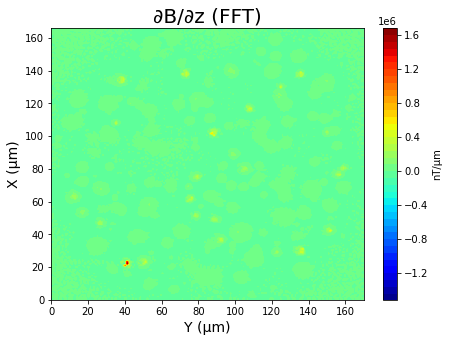

In [25]:
# Plot das Novas derivadas usando a continuação p/ cima por FFT

plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, (ddx)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, (ddy)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, (ddz)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [26]:
# Novas derivadas (em x e y) usando a continuação p/ cima por FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))

d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)


Text(0, 0.5, 'X (µm)')

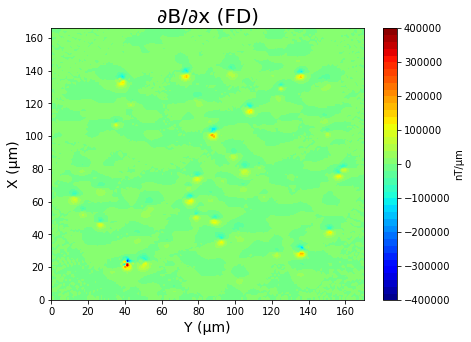

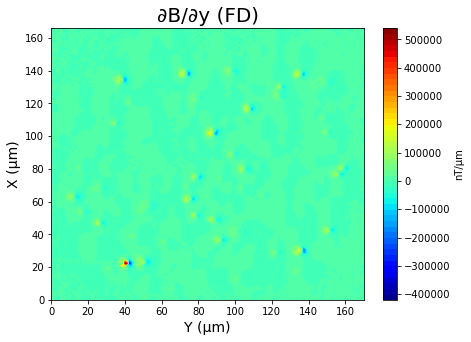

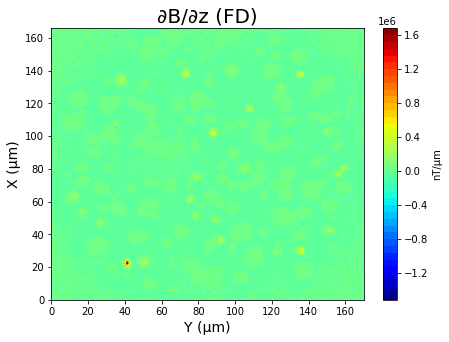

In [27]:
# Plot das novas derivadas (em x e y) usando a continuação p/ cima por FD

plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, (d_X)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, (d_Y)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


#d_Z_ = np.reshape(d_Z, (shape))

plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, d_Z*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



In [28]:
Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)


Text(0, 0.5, 'X (µm)')

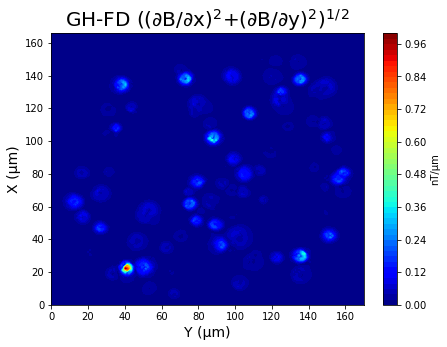

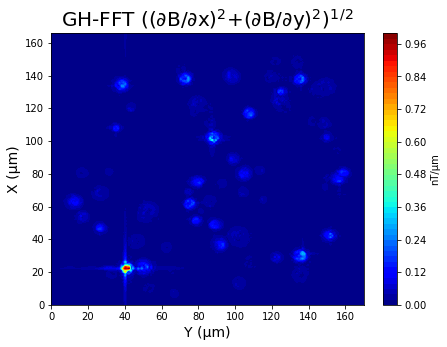

In [29]:
# Plot dos gradientes horizontais por FFT e FD

plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, (Horiz_Grad_FD/Horiz_Grad_FD.max() ), levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(7,5))
plt.contourf(x_plot, y_plot, (Horiz_Grad_FFT/Horiz_Grad_FFT.max() ), levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

Text(0, 0.5, 'Count')

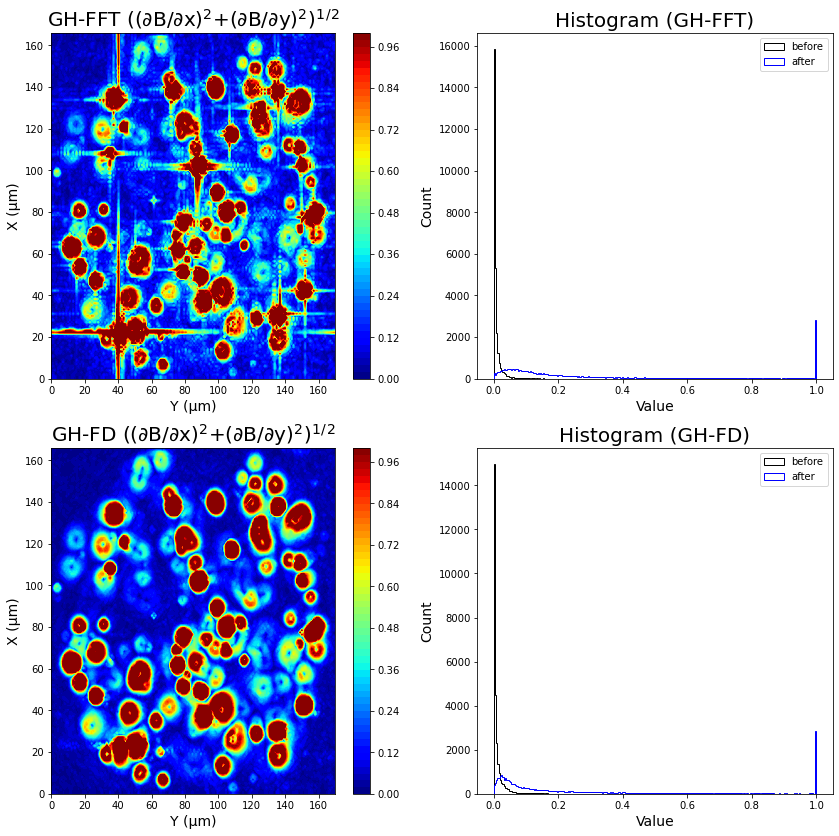

In [30]:
import skimage
image1 = Horiz_Grad_FFT/Horiz_Grad_FFT.max()

p_min, p_max = 0.5, 90

perc_min, perc_max = np.percentile(image1, (p_min, p_max))
image_FFT = skimage.exposure.rescale_intensity(image1, in_range=(perc_min, perc_max))

image2 = Horiz_Grad_FD/Horiz_Grad_FD.max()
perc_min, perc_max = np.percentile(image2, (p_min, p_max))
image_FD = skimage.exposure.rescale_intensity(image2, in_range=(perc_min, perc_max))



fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(221)
ax3 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


# plot FFT horizontal gradient

ax1_plot = ax1.contourf(x_plot, y_plot, image_FFT, levels=50, cmap='jet')
ax1.set_title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax3.hist(image1.ravel(), bins=256, histtype='step', color='k', label='before');
ax3.hist(image_FFT.ravel(), bins=256, histtype='step', color='b', label='after');
ax3.legend()
ax3.set_title('Histogram (GH-FFT)', fontsize=20)
ax3.set_xlabel('Value', fontsize=14)
ax3.set_ylabel('Count', fontsize=14)


# plot FD horizontal gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, image_FD, levels=50, cmap='jet')
ax2.set_title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax2_plot, ax=ax2)

ax4.hist(image2.ravel(), bins=256, histtype='step', color='k', label='before');
ax4.hist(image_FD.ravel(), bins=256, histtype='step', color='b', label='after');
ax4.legend()
ax4.set_title('Histogram (GH-FD)', fontsize=20)
ax4.set_xlabel('Value', fontsize=14)
ax4.set_ylabel('Count', fontsize=14)

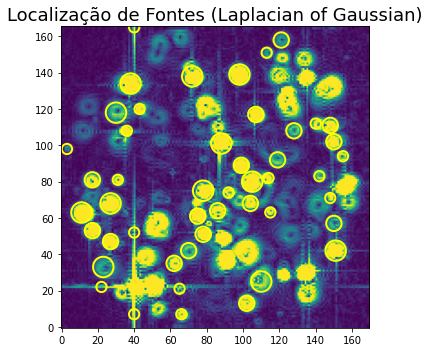

Spheres X position: 
[1.39435606e-04 1.16735546e-04 4.21951265e-05 8.10159245e-05
 4.66015171e-05 1.19349652e-05 1.37739953e-04 1.34727506e-04
 7.10466834e-06 6.81559696e-05 8.05413125e-05 3.45625272e-05
 6.39031487e-05 6.28229499e-05 8.89323603e-05 1.19620790e-04
 5.38919387e-05 1.01732240e-04 1.08104236e-04 7.48120721e-05
 1.02161372e-04 6.77553563e-05 8.38164303e-05 1.10785514e-04
 5.17004792e-05 6.15072185e-05 8.30741252e-05 9.43995836e-05
 1.13007950e-04 7.99013208e-05 7.42052775e-05 6.43366332e-05
 1.92057589e-05 7.24630214e-05 1.08429738e-04 9.06927863e-05
 2.38331658e-05 6.88617971e-06 1.64512490e-04 1.16483673e-04
 1.52083607e-04 4.30857970e-05 1.58324890e-04 5.15280857e-05
 5.61987411e-05 9.89660868e-05 3.22843207e-05 1.87982830e-05]

Spheres Y position: 
[9.81701685e-05 1.07695056e-04 1.51289184e-04 3.15525154e-05
 2.64634874e-05 1.02266063e-04 7.34336706e-05 3.91423250e-05
 6.69440686e-05 2.69139258e-05 1.68323732e-05 6.22146347e-05
 1.14914648e-04 1.29426440e-05 9.86708068

In [24]:
circles_FFT=sources_finder(image_FFT, threshold=0.19)

Xc_FFT, Yc_FFT, Zc_FFT = euler_window(circles_FFT, X_, Y_, Z_, d_, ddx, ddy, ddz, structural_index = 3.0, delta_z = delta_z)

print('Spheres X position: ')
print(Xc_FFT)

print()

print('Spheres Y position: ')
print(Yc_FFT)

print()

print('Spheres Z position: ')
print(Zc_FFT)

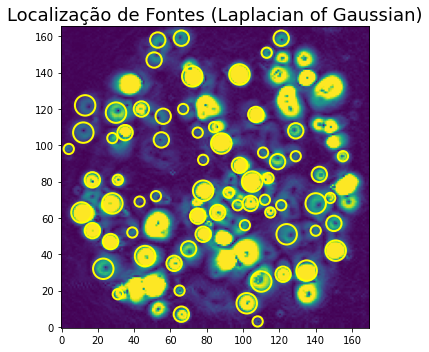

Spheres X position: 
[1.39371084e-04 4.21468271e-05 1.16793958e-04 1.37687374e-04
 7.07519331e-06 4.66364215e-05 1.21306526e-05 8.08865097e-05
 1.01749599e-04 6.81643051e-05 8.06344696e-05 3.44449342e-05
 3.91386326e-05 8.89864014e-05 6.28222501e-05 2.82785167e-05
 6.35844133e-05 1.08214495e-04 7.48000757e-05 1.19842795e-04
 5.38139626e-05 2.95685379e-05 5.17314184e-05 8.42310437e-05
 6.14729969e-05 6.75056651e-05 8.38224623e-05 9.42978476e-05
 7.98737214e-05 1.58297208e-05 6.40582260e-05 7.42343077e-05
 1.08297452e-04 9.01449902e-05 2.35446590e-05 1.09508437e-04
 1.16374512e-04 1.90528273e-05 7.22906610e-05 4.38192235e-05
 3.15500883e-05 1.58749532e-04 1.52135926e-04 5.61313730e-05
 1.59694214e-04 1.60044902e-04 1.05959264e-04 6.75889102e-05
 9.89260737e-05 5.47224544e-05 5.16837569e-05 6.69630103e-05
 1.46869448e-04 1.07818388e-04 1.04782889e-04 9.20492959e-05
 5.25620965e-05 7.32048985e-05 1.14526204e-04 5.30722177e-05
 6.81560909e-05 1.23157846e-04 7.04283536e-05 9.46875458e-05
 1.

In [26]:
circles_FD=sources_finder(image_FD, threshold=0.09)

Xc_FD, Yc_FD, Zc_FD = euler_window(circles_FD, X_, Y_, Z_, d_, d_X, d_Y, d_Z, structural_index = 3.0, delta_z = delta_z)

print('Spheres X position: ')
print(Xc_FD)

print()

print('Spheres Y position: ')
print(Yc_FD)

print()

print('Spheres Z position: ')
print(Zc_FD)

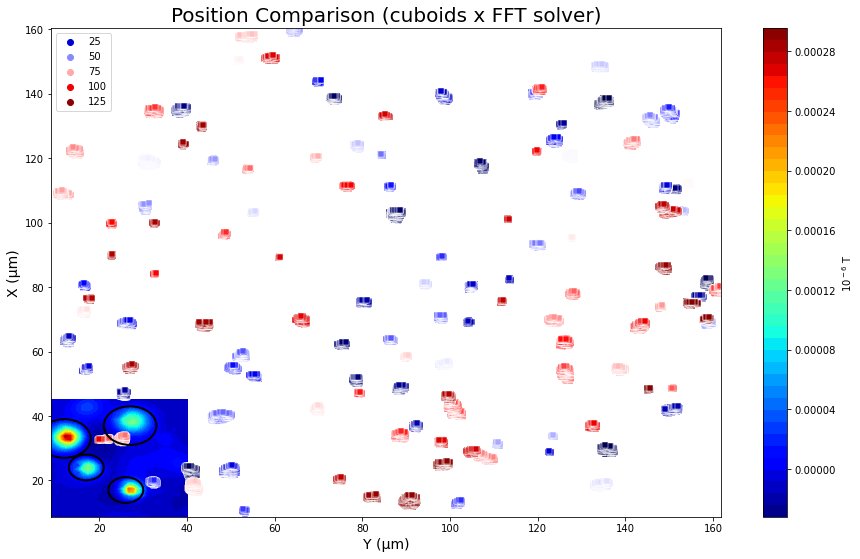

In [220]:
import seaborn as sns

cuboids = np.loadtxt('cuboids.csv', delimiter=',', skiprows=1)
x = cuboids[:, 0]
y = cuboids[:, 1]

sources= cuboids[:, 6]

xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(1, 1, 1)
plt.contourf(x_plot, y_plot, d_, levels=50, cmap='jet')
plt.colorbar(label='10$^-$$^6$ T')


i = 0
j = 1
k = 2

while i <= int(np.shape(circles_FFT)[0]-1):
    c = plt.Circle((circles_FFT[j], circles_FFT[i]), circles_FFT[k], color='k', linewidth=2, fill=False)
    ax.add_patch(c)
    i = i+3
    j = j+3
    k = k+3
    

sns.scatterplot(x=x/6, y=y/6, marker='s', hue=sources, palette='seismic') # divide by the ste
plt.title('Position Comparison (cuboids x FFT solver)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.xlim(np.min(x/6)-1, np.max(x/6)-1)
plt.ylim(np.min(y/6)-1, np.max(y/6)-1)

plt.show()

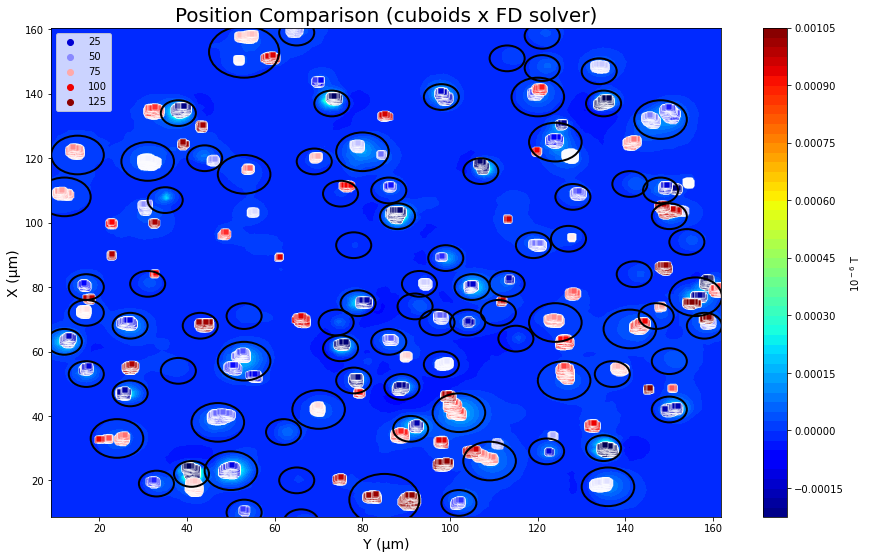

In [189]:
import seaborn as sns

cuboids = np.loadtxt('cuboids.csv', delimiter=',', skiprows=1)
x = cuboids[:, 0]
y = cuboids[:, 1]

sources= cuboids[:, 6]

xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(1, 1, 1)
plt.contourf(x_plot, y_plot, d_, levels=50, cmap='jet')
plt.colorbar(label='10$^-$$^6$ T')


i = 0
j = 1
k = 2

while i <= int(np.shape(circles_FD)[0]-1):
    c = plt.Circle((circles_FD[j], circles_FD[i]), circles_FD[k], color='k', linewidth=2, fill=False)
    ax.add_patch(c)
    i = i+3
    j = j+3
    k = k+3
    

sns.scatterplot(x=x/6, y=y/6, marker='s', hue=sources, palette='seismic') # divide by the step
plt.title('Position Comparison (cuboids x FD solver)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.xlim(np.min(x/6)-1, np.max(x/6)-1)
plt.ylim(np.min(y/6)-1, np.max(y/6)-1)

plt.show()

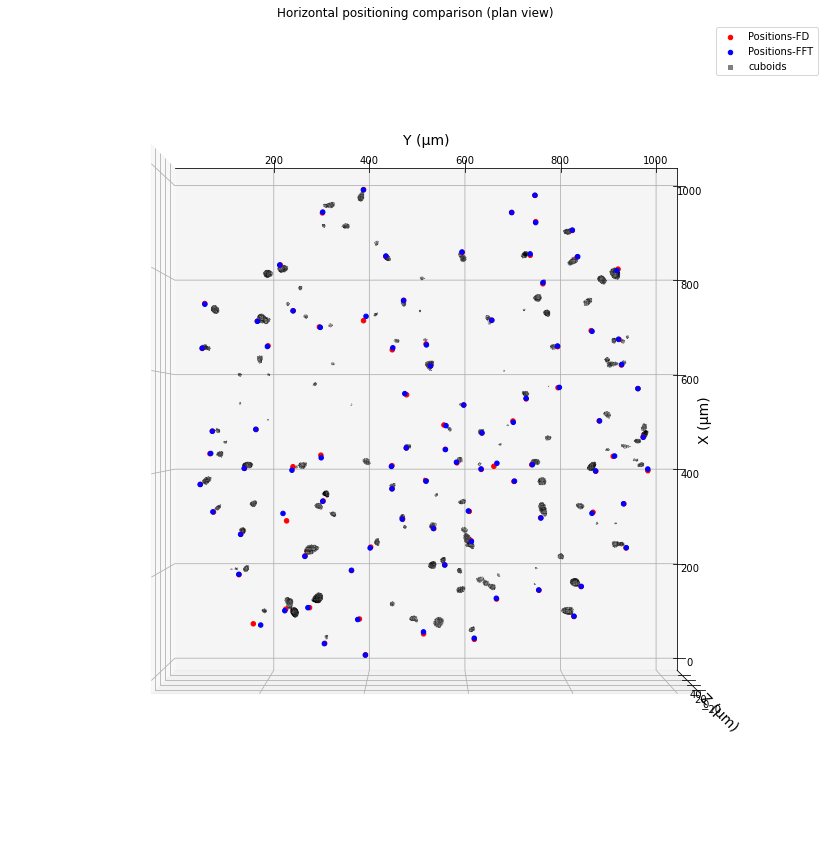

In [190]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np


x_position = cuboids[:, 0]
y_position = cuboids[:, 1]
z_position = cuboids[:, 2]
a_cuboid   = cuboids[:, 3]
b_cuboid   = cuboids[:, 4]
c_cuboid   = cuboids[:, 5]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for i in range(np.size(x_position)):
  
    x = x_position[i]
    y = y_position[i]
    z = z_position[i]
    a = a_cuboid[i]
    b = b_cuboid[i]
    c = c_cuboid[i]
    
    
    v1 = [x+a, y+b, z+c]
    v2 = [x+a, y-b, z+c]
    v3 = [x-a, y-b, z+c]
    v4 = [x-a, y+b, z+c]
    v5 = [x+a, y+b, z-c]
    v6 = [x+a, y-b, z-c]
    v7 = [x-a, y-b, z-c]
    v8 = [x-a, y+b, z-c]

    vertices = [v1, v2, v3, v4, v5, v6, v7, v8]
    
    for p in vertices:
        ax.scatter3D(p[0], p[1], p[2], color='k', marker=',', alpha=0.0)
    
    verts = [ 
              [vertices[0],vertices[3],vertices[7],vertices[4]],
              [vertices[3],vertices[7],vertices[6],vertices[2]],
              [vertices[2],vertices[1],vertices[5],vertices[6]],
              [vertices[0],vertices[4],vertices[5],vertices[1]],
              [vertices[0],vertices[1],vertices[2],vertices[3]],
              [vertices[4],vertices[5],vertices[6],vertices[7]]
            ]


    collection = Poly3DCollection(verts, linewidths=0.0001, edgecolors='k', alpha=0.1, zsort='min')
    face_color = 'k'
    collection.set_facecolor(face_color)
    ax.add_collection3d(collection)


ax.scatter3D(Yc_FD*m2microm*6, Xc_FD*m2microm*6, Zc_FD*m2microm*6, color='r', alpha=1.0, marker='o', label='Positions-FD')
ax.scatter3D(Yc_FFT*m2microm*6, Xc_FFT*m2microm*6, Zc_FFT*m2microm*6, color='b', alpha=1.0, marker='o', label='Positions-FFT')
ax.scatter3D([], [], [], color='gray', alpha=1.0, marker='s', label='cuboids')

ax.set_title('Horizontal positioning comparison (plan view)')
ax.invert_zaxis()

ax.set_xlabel('Y (µm)', fontsize=14)
ax.set_ylabel('X (µm)', fontsize=14)
ax.set_zlabel('Z (µm)', fontsize=14)

ax.legend()

ax.azim = -90
ax.dist = 10
ax.elev = 90

plt.show()

KeyboardInterrupt: 

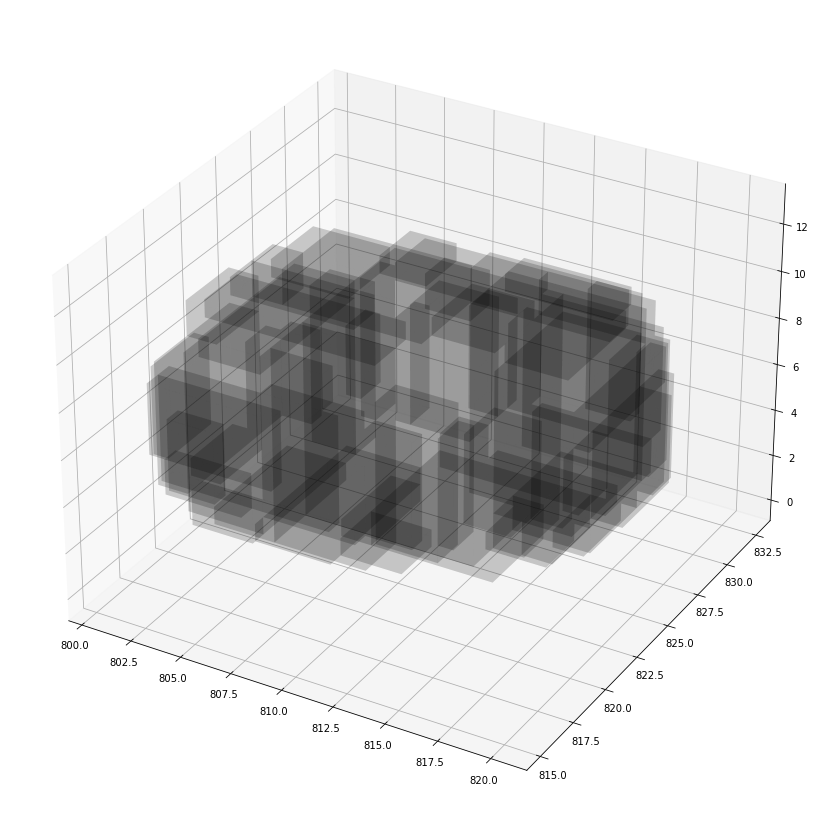

In [247]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np


x_position = cuboids[:, 0]
y_position = cuboids[:, 1]
z_position = cuboids[:, 2]
a_cuboid   = cuboids[:, 3]
b_cuboid   = cuboids[:, 4]
c_cuboid   = cuboids[:, 5]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for i in range(np.size(x_position)):
  
    x = x_position[i]
    y = y_position[i]
    z = z_position[i]
    a = a_cuboid[i]
    b = b_cuboid[i]
    c = c_cuboid[i]
    
    
    v1 = [x+a, y+b, z+c]
    v2 = [x+a, y-b, z+c]
    v3 = [x-a, y-b, z+c]
    v4 = [x-a, y+b, z+c]
    v5 = [x+a, y+b, z-c]
    v6 = [x+a, y-b, z-c]
    v7 = [x-a, y-b, z-c]
    v8 = [x-a, y+b, z-c]

    vertices = [v1, v2, v3, v4, v5, v6, v7, v8]
    
    for p in vertices:
        ax.scatter3D(p[0], p[1], p[2], color='k', marker=',', alpha=0.0)
    
    verts = [ 
              [vertices[0],vertices[3],vertices[7],vertices[4]],
              [vertices[3],vertices[7],vertices[6],vertices[2]],
              [vertices[2],vertices[1],vertices[5],vertices[6]],
              [vertices[0],vertices[4],vertices[5],vertices[1]],
              [vertices[0],vertices[1],vertices[2],vertices[3]],
              [vertices[4],vertices[5],vertices[6],vertices[7]]
            ]


    collection = Poly3DCollection(verts, linewidths=0.0001, edgecolors='k', alpha=0.1, zsort='min')
    face_color = 'k'
    collection.set_facecolor(face_color)
    ax.add_collection3d(collection)


ax.scatter3D(Yc_FD*m2microm*6, Xc_FD*m2microm*6, Zc_FD*m2microm*6, color='r', alpha=1.0, marker='o', label='Positions-FD')
ax.scatter3D(Yc_FFT*m2microm*6, Xc_FFT*m2microm*6, Zc_FFT*m2microm*6, color='b', alpha=1.0, marker='o', label='Positions-FFT')
ax.scatter3D([], [], [], color='gray', alpha=1.0, marker='s', label='cuboids')

ax.set_title('Horizontal positioning comparison (plan view)')
ax.invert_zaxis()

ax.set_xlabel('Y (µm)', fontsize=14)
ax.set_ylabel('X (µm)', fontsize=14)
ax.set_zlabel('Z (µm)', fontsize=14)

ax.legend()

ax.azim = -90
ax.dist = 10
ax.elev = 0

plt.show()

In [27]:
def least_square_solver(X, Y, Z, Xc, Yc, Zc, d):

    M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)
    h = np.linalg.solve(M.T@M, M.T@d)
    
    
    w = int(np.size(h))
    h_T = np.reshape(h, (int(w/3),3) )
    
    hx = []
    hy = []
    hz = []
    
    for row in range (np.shape(h_T)[0]):
        hx = np.append(hx, h_T[row, 0] )
        hy = np.append(hy, h_T[row, 1] )
        hz = np.append(hz, h_T[row, 2] )
        
    
    return(hx, hy, hz, M)





def directions(hx, hy, hz, plot = False):
    D = []
    I = []
    
    for i in range (np.size(hx)):

        I = np.append( I, (math.atan2( hz[i], (np.sqrt(hy[i]**2+hx[i]**2)) ) )* (180/np.pi))
        D = np.append( D, (math.atan2( hy[i],  hx[i] ) * (180/np.pi) ) )
        
    if plot == True:
        settings['figsize'] = (7, 7)
        
        s = StereoNet(grid=True, legend=True)
        s.title('Recovered Directions')
        
        for w in range (np.size(D)):
            
            if I[w] >= 0:
                symbol = 'o'
                color = 'r'
            else:
                symbol = 'o'
                color = 'k'
            
            if w == 0:
                s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)
            else:
                s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)
           
    
    return(D, I)
        

    
    


hx_FFT, hy_FFT, hz_FFT, M_FFT = least_square_solver(X, Y, Z, Xc_FFT, Yc_FFT, Zc_FFT, d)

print(hx_FFT)
print(hy_FFT)
print(hz_FFT)

[-1.61157505e-21 -3.51711016e-22 -1.82841125e-21 -2.38088549e-22
 -1.29282250e-21 -5.22741871e-21 -2.15786408e-21  1.73269124e-21
  4.60368803e-22  9.19969839e-22  5.58244603e-22 -4.52014919e-22
 -1.48574297e-22 -1.54226721e-21  1.21899737e-22 -1.54376063e-21
  4.73045283e-22 -2.07769777e-21  1.52881888e-22 -1.57019403e-21
 -3.60800687e-22 -2.18179090e-21  2.25693274e-21  1.72878587e-22
  2.98739052e-22 -7.52651725e-22 -3.42027919e-22 -1.99097411e-22
  1.37876677e-21 -9.02665838e-22 -7.39543244e-24  2.72044583e-21
 -4.61933234e-23  1.90377134e-22 -1.31008725e-21 -5.32505461e-21
 -1.25007765e-20 -8.24118410e-24  1.28563322e-25 -1.03118268e-20
  5.07943750e-22  3.07062320e-21  1.49032568e-22 -3.20888914e-21
 -2.85676060e-21  8.86906496e-24 -2.56391807e-21 -1.90963391e-24]
[-1.77822393e-22 -9.16089267e-22 -5.16404856e-22  6.24470763e-23
 -8.20672785e-22 -2.67396165e-21  2.16484815e-21  4.41318820e-21
  8.70173413e-23  5.49190290e-22 -4.88889255e-23 -9.21760704e-22
 -2.93164371e-22  3.4088

In [28]:
hx_FD, hy_FD, hz_FD, M_FD = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)

print(hx_FD)
print(hy_FD)
print(hz_FD)

[-1.91277870e-21 -2.03154192e-21 -2.24954143e-22 -2.59292957e-21
  4.72019261e-22 -1.36834307e-21 -4.46465145e-21 -3.30414846e-22
 -1.89409658e-21  9.93988169e-22  6.68064055e-22 -6.00799750e-22
  3.41349224e-21  2.44098300e-22 -1.65116976e-21 -1.14182706e-21
 -4.50875333e-22 -2.19349078e-23 -1.62643911e-21 -1.66488275e-21
  3.51276658e-22 -1.39119223e-21  3.34025531e-22  2.16546599e-21
 -9.08853023e-22 -2.09021316e-21 -1.18750408e-22 -4.28103329e-22
 -1.09104153e-21 -8.25191349e-21  1.88046812e-21  6.10046509e-23
 -1.70738892e-21 -6.66053831e-21 -1.30555489e-20 -3.16928112e-22
 -1.29275946e-20 -9.42811368e-23 -5.91450230e-23  4.63325516e-21
 -4.51464285e-21  4.25375805e-22  6.09162734e-22 -1.90984787e-21
  5.28902983e-21 -5.25512327e-22  2.66552426e-21  2.91215732e-22
  9.53214597e-24 -1.97807624e-21  5.39897365e-21 -5.42675382e-21
 -1.01619535e-20 -2.21443233e-21  7.49640268e-22 -1.83470300e-22
 -1.02197257e-21  1.57631562e-21 -9.74603639e-22 -4.74969982e-21
 -3.87972492e-21  1.84658

[-123.2773975   101.59301658   69.40873846  130.84007962 -125.55045108
 -141.21429093 -170.20400036 -144.20832889  111.53744211 -168.202673
  -35.72910996 -152.92074217   99.66137527  117.507003    -99.25636372
  -25.18116447   80.48004681 -106.39139557   23.25108812  -83.62023764
  -98.43936986 -111.35334163 -168.43149572  151.33096123   32.30719793
 -165.1883518     3.2653074   179.78565781   -8.25547089 -170.21102204
  -27.46242943   -3.658213    -11.77229526 -102.57677092 -145.5110196
  -53.4816994    43.05241522  -50.74315739 -122.69422745 -167.50582319
  -10.94974117  -32.34796838  -85.6068027   159.05992507 -154.30219271
  153.44992806 -139.93185844   -0.49092311  -61.85428032  -19.33740591
 -166.98624356  158.09741458  -69.96034665 -130.77852773  -98.1346071
  -23.42861768 -110.32849039    8.19133916   70.60115049  -52.29062369
  124.40397668  -27.82047873 -123.4481749   166.44042337 -170.54534623
  152.73551346    5.40417149 -126.64935092  -60.58269052]
[ 74.30199037  54.36887

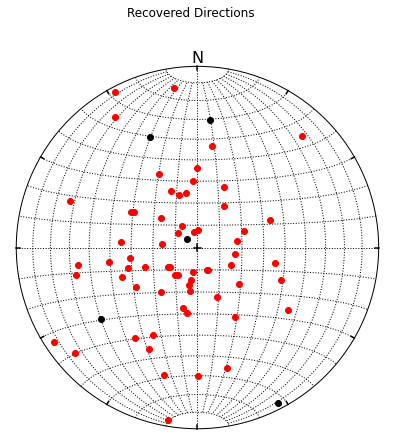

In [388]:
D_FFT, I_FFT = directions(hx_FFT, hy_FFT, hz_FFT, plot=True)

print(D_FFT)
print(I_FFT)

print()

print(np.mean(D_FFT))
print(np.mean(I_FFT))

[ 177.21241443 -159.31803264 -102.55892639  139.50679108    4.78780672
 -148.91899497 -147.64845284  166.73892968 -137.14158876   36.52338934
   -2.21416312 -118.95365749  -15.60769994  -81.02344396  113.46335878
  146.87343454 -153.15821028   94.72512693  114.38821216 -161.06229884
   71.47566836  107.56861263   13.88722885   37.01409826 -127.95152229
 -171.52264644  -98.14986067  174.40459145 -105.07485861 -141.3157706
  -44.57431249  -84.13166015  138.27340711  162.16479898  177.33114984
  103.00754468 -167.50210587 -162.2663044  -110.43965774   -5.96096882
 -153.9306918    18.6781634   -30.20056897 -167.77361595  -19.24841793
  152.32153277   49.84675867  -84.85203893  -75.57972393  157.86394787
  -57.44205519 -136.64285534  173.75103332 -160.42074243   41.95283843
  155.13119306  133.15258265  -17.33540865  119.26739344  172.94216455
 -108.55538718  -47.95550886 -111.46875929  108.52295201  162.68810973
 -108.34097141 -168.73240621 -178.87183297  -17.0166773 ]
[ 76.42094043  72.14

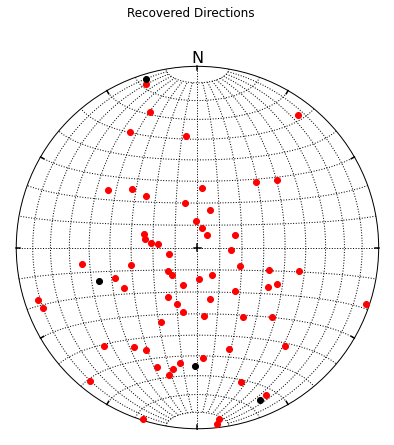

In [29]:
D_FD, I_FD = directions(hx_FD, hy_FD, hz_FD, plot=True)

print(D_FD)
print(I_FD)

print()

print(np.mean(D_FD))
print(np.mean(I_FD))

In [419]:
def robust_solver(X, Y, Z, Xc, Yc, Zc, d):
    
    
    M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)
    h_0 = np.linalg.solve(M.T@M, M.T@d) # least square (Rk, k=0)
    e = 1.0E-20

    r_k = 1/(np.absolute(np.matmul(M,h_0) - d + e))
    R_k = np.zeros((np.size(d), (np.size(d))))
    np.fill_diagonal(R_k, r_k)


    for i in range(10):
        print(i)
        ### primeira iteração
        M_T = M.T
        M_T_R = np.matmul(M_T, R_k)

        M_M_T_R = np.matmul(M_T_R, M)


        d_M_T_R = np.matmul(M_T_R, d)

        h = np.linalg.solve(M_M_T_R, d_M_T_R)   

        #### recalculando R_k p/ proxima iteração
        r_k = 1/(np.absolute(np.matmul(M,h) - d + e))
        R_k = np.zeros((np.size(d), (np.size(d))))
        np.fill_diagonal(R_k, r_k)
        
    
    w = int(np.size(h))
    h_T = np.reshape(h, (int(w/3),3) )
    
    hx = []
    hy = []
    hz = []
    
    for row in range (np.shape(h_T)[0]):
        hx = np.append(hx, h_T[row, 0] )
        hy = np.append(hy, h_T[row, 1] )
        hz = np.append(hz, h_T[row, 2] )
        
    
    return(hx, hy, hz, M)


hx_FD, hy_FD, hz_FD, M_FD = robust_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
print(hx_FD)
print(hy_FD)
print(hz_FD)

0
1
2
3
4
5
6
7
8
9
[ 7.81312458e-22  5.73670190e-22  3.35660570e-21  4.47707260e-22
 -4.16758887e-22  1.23196563e-21]
[-3.38391381e-22  1.51539830e-21  8.40788706e-21  5.51849708e-23
 -1.20902028e-21 -1.40689160e-21]
[2.34314452e-21 7.12065624e-21 1.05829494e-20 8.81719807e-22
 1.62202526e-21 1.00916033e-20]


[ -23.41774238   69.26530537   68.23707426    7.02690688 -109.01947896
  -48.7925047 ]
[70.03002467 77.18029776 49.45479984 62.90531972 51.74710225 79.50175164]

-6.116739921029542
65.1365493128417


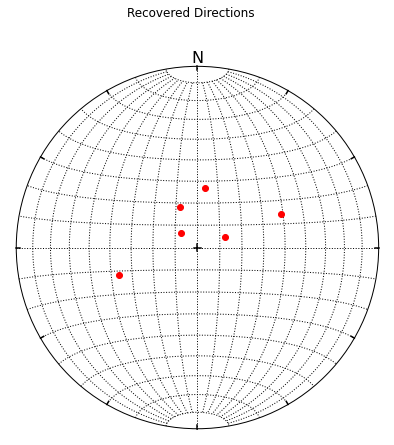

In [420]:
D_FD, I_FD = directions(hx_FD, hy_FD, hz_FD, plot=True)

print(D_FD)
print(I_FD)

print()

print(np.mean(D_FD))
print(np.mean(I_FD))